In [8]:
## Citation: Karnika Kapoor, 2021, https://www.kaggle.com/code/karnikakapoor/music-generation-lstm/notebook
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
from IPython.display import Image, Audio  
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.train(42)

In [12]:
# Loading the list of chopin's midi files as stream 
filepath = "chopin/"
# Getting midi files
music_files= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        music_files.append(midi)

In [13]:
# Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
# Getting the list of notes as Corpus
Corpus= extract_notes(music_files)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 57894


In [42]:
   
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 # Incremental
    for i in Snippet:
        # If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") # Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi


In [43]:
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 263


In [68]:
# Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
# Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrence for a note in Corpus: 204.38403041825094
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


In [18]:
# Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m = key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 270


In [19]:
# Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53753


In [20]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) # length of corpus
L_symb = len(symb) # length of total unique characters

# Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53753
Number of unique characters: 263


In [21]:
# Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53713


In [22]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [23]:
#Taking out a subset of data to be used as train
X_train, X_train, y_train, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [25]:
# Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 263)               67591     
                                                                 
Total params: 1973511 (7.53 MB)
Trainable params: 197351

In [27]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=50)

Epoch 1/50
168/168 [==============================] - 50s 296ms/step - loss: 4.5243
Epoch 2/50
168/168 [==============================] - 49s 294ms/step - loss: 4.4696
Epoch 3/50
168/168 [==============================] - 51s 303ms/step - loss: 4.4450
Epoch 4/50
168/168 [==============================] - 52s 308ms/step - loss: 4.4434
Epoch 5/50
168/168 [==============================] - 54s 321ms/step - loss: 4.4235
Epoch 6/50
168/168 [==============================] - 52s 310ms/step - loss: 4.4150
Epoch 7/50
168/168 [==============================] - 51s 304ms/step - loss: 4.4023
Epoch 8/50
168/168 [==============================] - 51s 301ms/step - loss: 4.3989
Epoch 9/50
168/168 [==============================] - 50s 299ms/step - loss: 4.3824
Epoch 10/50
168/168 [==============================] - 50s 300ms/step - loss: 4.3748
Epoch 11/50
168/168 [==============================] - 51s 301ms/step - loss: 4.3718
Epoch 12/50
168/168 [==============================] - 51s 304ms/step - lo

[Text(0.5, 0, 'Epochs')]

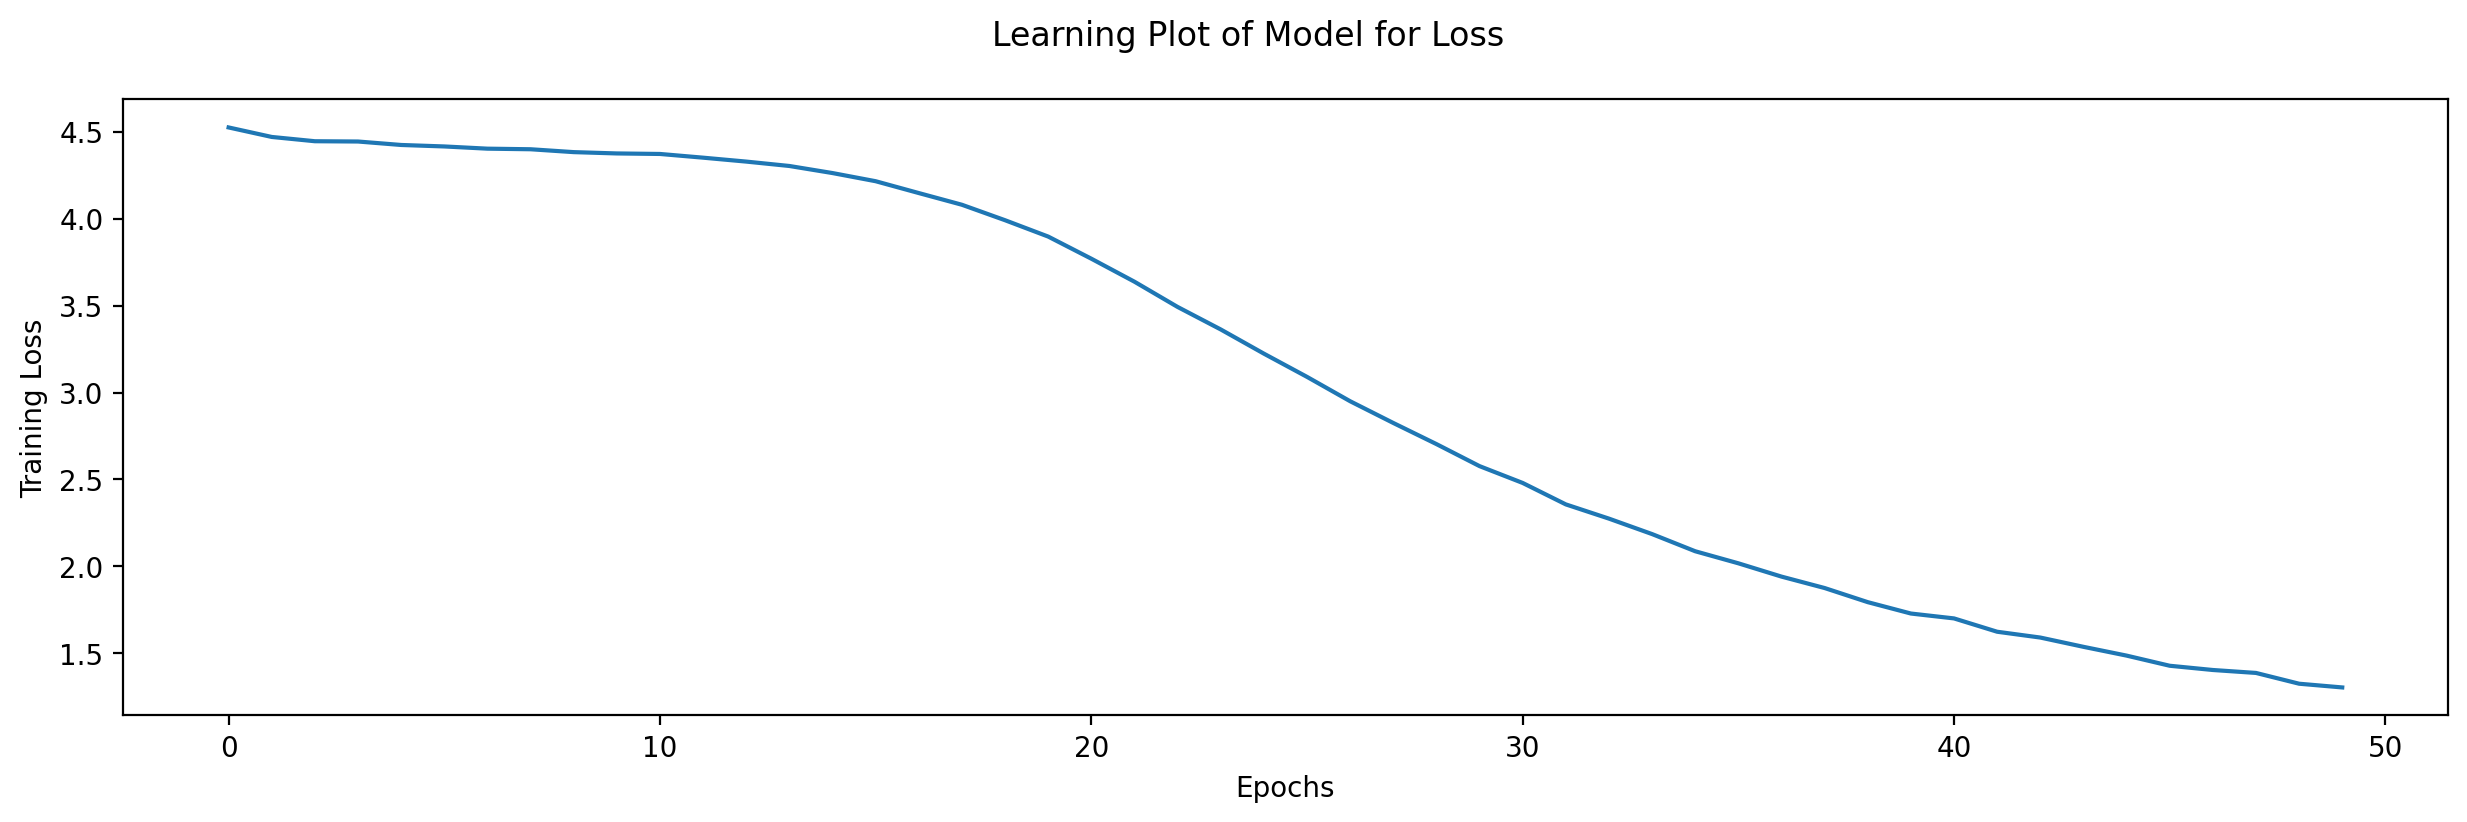

In [67]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"])
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [60]:
def Malody_Generator(Note_Count):
    train = X_train[np.random.randint(0,len(X_train)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        train = train.reshape(1,length,1)
        prediction = model.predict(train, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        train = np.insert(train[0],len(train[0]),index_N)
        train = train[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)

In [61]:
# To save the generated melody
Melody.write('midi','Melody_Generated.mid')

'Melody_Generated.mid'

In [64]:
import pygame
import time

def play_midi(file_path):
    # Initialize pygame mixer
    pygame.mixer.init()
    # Load the MIDI file
    pygame.mixer.music.load(file_path)

    # Start playing the MIDI file
    pygame.mixer.music.play()
    time.sleep(10)
    pygame.mixer.music.stop()
    



In [56]:
play_midi('chopin/chpn-p24.mid') # Do not key interrupt, or it will play for 10 mins

In [63]:
play_midi('Melody_Generated.mid')